In [1]:
import sys
sys.path.append("../../..")
import matplotlib.pyplot as plt
import numpy as np
from anastruct.basic import converge
from anastruct.material.profile import HEA, IPE
from anastruct.fem.system import SystemElements, Vertex
from anastruct.material.units import to_kNm2, to_kN

In [3]:
# constants
E = 2.1e5 / 1.3
b = 5 * 1.09
q_water = 10    

# axes height levels
h_1 = 0
h_2 = 0.258
h_3 = 0.046
h_4 = 0.274
h_5 = 0.032
h_6 = 0.15

# beam spans
span_1 = span_2 = 21.9
span_3 = 8.9

# Vertices at the axes
p1 = Vertex(0, h_1)
p2 = Vertex(span_1 * 0.5, h_2)
p3 = Vertex(span_1, h_3)
p4 = Vertex(span_1 + span_2 * 0.5, h_4)
p5 = Vertex(span_1 + span_2, h_5)
p6 = Vertex(span_1 + span_2 + span_3, h_6)

In [5]:
def structure():
    """
    Build the structure from left to right, starting at axis 1.
    
    variables:
    EA = Young's modulus * Area
    EI = Young's modulus * moment of Inertia
    g = Weight [kN/ m]
    elements = reference of the element id's that were created
    dl = c.t.c distance different nodes.
    """
    
    dl = 0.2
    
    
    ## SPAN 1 AND 2
    
    # The elements between axis 1 and 3 are an IPE 450 member.
    EA = to_kN(E * IPE[450]['A'])  # Y
    EI = to_kNm2(E * IPE[450]["Iy"])
    g = IPE[450]['G'] / 100
    
    # New system.
    ss = SystemElements(mesh=3, plot_backend="mpl")
    
    # span 1
    first = dict(
        spring={1: 9e3}, 
        mp={1: 70},
    )
    
    elements = ss.add_multiple_elements(location=[p1, p2], dl=dl, first=first, EA=EA, EI=EI, g=g)
    elements += ss.add_multiple_elements(location=p3, dl=dl, EA=EA, EI=EI, g=g)
    
    # span 2
    first = dict(
        spring={1: 40e3},
        mp={1: 240}
    )
    elements += ss.add_multiple_elements(location=p4, dl=dl, first=first, EA=EA, EI=EI, g=g)
    elements += ss.add_multiple_elements(location=p5, dl=dl, EA=EA, EI=EI, g=g)
    
    
    ## SPAN 3
    
    # span 3
    # different IPE
    g = IPE[240]['G'] / 100
    EA = to_kN(E * IPE[240]['A'])
    EI = to_kNm2(E * IPE[240]["Iy"])
    first = dict(
        spring={1: 15e3}, 
        mp={1: 25},
    )
    
    elements += ss.add_multiple_elements(location=p6, first=first, dl=dl, EA=EA, EI=EI, g=g)
    
    # Add a dead load of -2 kN/m to all elements.
    ss.q_load(-2, elements, direction="y")
    
    
    ## COLUMNS
    
    # column height
    h = 7.2
    
    # left column
    EA = to_kN(E * IPE[220]['A'])
    EI = to_kNm2(E * HEA[220]["Iy"])
    left = ss.add_element([[0, 0], [0, -h]], EA=EA, EI=EI)
    
    # right column
    EA = to_kN(E * IPE[180]['A'])
    EI = to_kNm2(E * HEA[180]["Iy"])
    right = ss.add_element([p6, Vertex(p6.x, -h)], EA=EA, EI=EI)
    
        
    ## SUPPORTS
    
    # node ids for the support
    id_left = max(ss.element_map[left].node_map.keys())
    id_top_right = min(ss.element_map[right].node_map.keys())
    id_btm_right = max(ss.element_map[right].node_map.keys())
    
    # Add supports. The location of the supports is defined with the nodes id.
    ss.add_support_hinged((id_left, id_btm_right))

    # Retrieve the node ids at axis 2 and 3
    id_p3 = ss.find_node_id(p3)
    id_p5 = ss.find_node_id(p5)

    ss.add_support_roll(id_top_right, direction=1)
    
    # Add translational spring supports at axes 2 and 3
    ss.add_support_spring(id_p3, translation=2, k=2e3, roll=True)
    ss.add_support_spring(id_p5, translation=2, k=3e3, roll=True)
    return ss


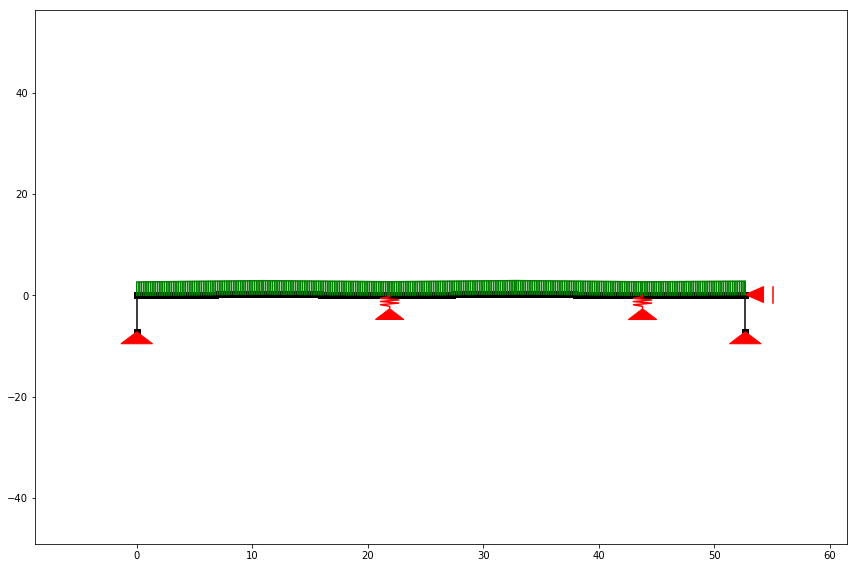

In [6]:
ss = structure()
ss.show_structure(verbosity=1, scale=1)

In [7]:

def water_load(ss, water_height, deflection=None):
    """
    :param ss: (SystemElements) object.
    :param water_height: (flt) Water level.
    :param deflection: (array) Computed deflection.
    :return (flt) The cubic meters of water on the structure
    """
    
    # The horizontal distance between the nodes.
    dl = np.diff(ss.nodes_range('x'))
    
    if deflection is None:
        deflection = np.zeros(len(ss.node_map))
        
    # Height of the nodes
    y = np.array(ss.nodes_range('y'))
    
    # An array with point loads. 
    # cubic meters * weight water
    force_water = (water_height - y[:-3] - deflection[:-3]) * q_water * b * dl[:-2]

    cubics = 0
    n = force_water.shape[0] 
    for k in ss.node_map:
        if k > n:
            break
        point_load = force_water[k - 1]
        
        if point_load > 0:
            ss.point_load(k, Fx=0, Fz=-point_load)
            cubics += point_load / q_water
            
    return cubics


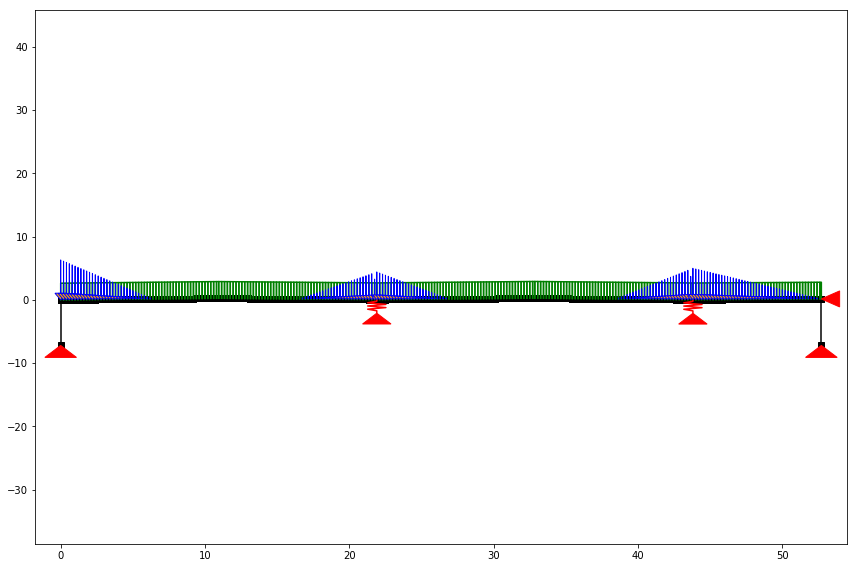

In [8]:
ss = structure()
a = water_load(ss, water_height=0.15)
ss.show_structure(verbosity=1, scale=0.8)

In [9]:
def det_water_height(c, deflection=None):
    """
    :param c: (flt) Cubic meters.
    :param deflection: (array) Node deflection values.
    :return (SystemElement, flt) The structure and the redistributed water level is returned.
    """
    wh = 0.1
    
    while True:
        ss = structure()
        cubics = water_load(ss, wh, deflection)
        
        factor = converge(cubics, c)
        if 0.9999 <= factor <= 1.0001:
            return ss, wh

        wh *= factor

In [86]:
cubics = [0]
water_heights = [0]

deflection = None
max_water_level = 0

# Iterate from 8 m3 to 15 m3 of water.

for cubic in reversed(11 - np.logspace(0, 1, 7)):  # This loop computes the results per m3 of storaged water.
    wh = 0.05
    lastwh = 0.2
    
    print(f"Starting analysis of {cubic} m3")
                        
    c = 1
    for _ in range(100):  # This loop redistributes the water until the water level converges.
        
        # redistribute the water 
        ss, wh = det_water_height(cubic, deflection)
        
        # Do a non linear calculation!!
        ss.solve(max_iter=100, verbosity=1)
        deflection = ss.get_node_result_range("uy")
        
        # Some breaking conditions
        if min(deflection) < -1:
            print(min(deflection), "Breaking due to exceeding max deflection")
            break
        if 0.9999 < lastwh / wh < 1.001:
            print(f"Convergence in {c} iterations.")
            cubics.append(cubic)
            water_heights.append(wh)
            break
        
        lastwh = wh
        c += 1
        
    if wh > max_water_level:
        max_water_level = wh
    else:
        print("Breaking. Water level isn't rising.")
        break


Starting analysis of 1.0 m3
Convergence in 4 iterations.
Starting analysis of 4.187079309420389 m3
Convergence in 4 iterations.
Starting analysis of 6.358411166387222 m3
Convergence in 4 iterations.
Starting analysis of 7.83772233983162 m3
Convergence in 4 iterations.
Starting analysis of 8.845565309968116 m3
Convergence in 4 iterations.
Starting analysis of 9.53220073237793 m3
Convergence in 56 iterations.
Breaking. Water level isn't rising.


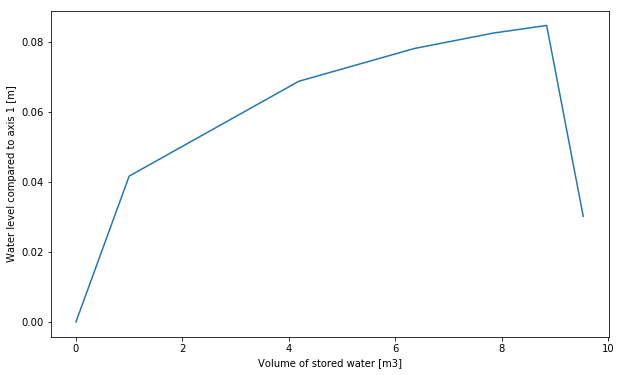

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(cubics, water_heights)
plt.ylabel("Water level compared to axis 1 [m]")
plt.xlabel("Volume of stored water [m3]")
plt.show()

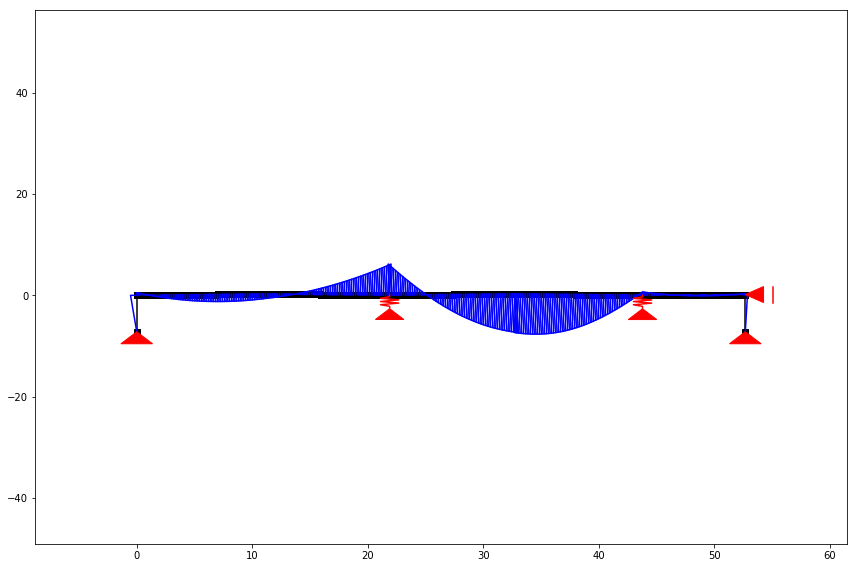

In [58]:
ss.show_bending_moment(verbosity=1)

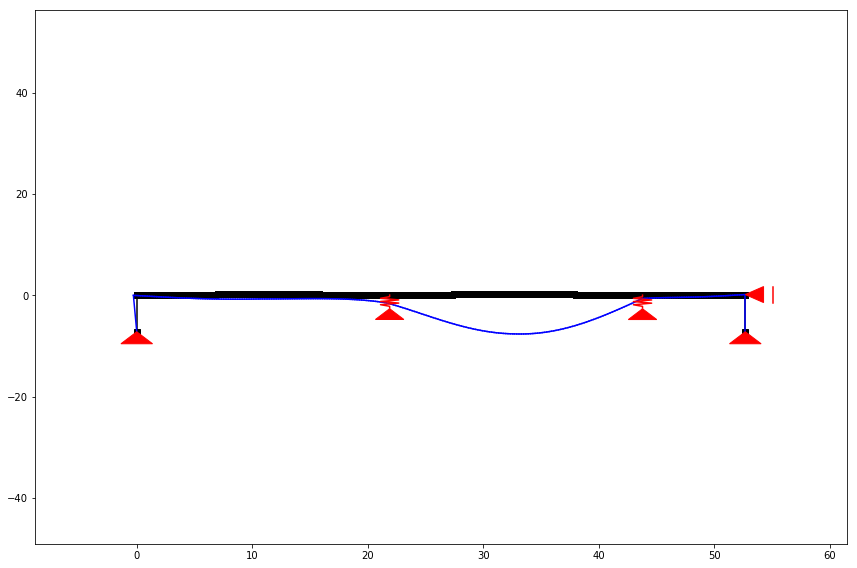

In [53]:
ss.show_displacement(verbosity=1)

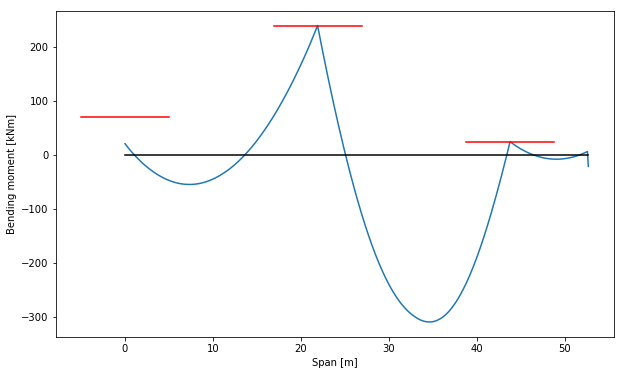

In [77]:
plt.figure(figsize=(10, 6))

plt.plot(ss.nodes_range('x')[:-2], [el.bending_moment[0] for el in list(ss.element_map.values())[:-1]])
a = 0
plt.plot([0, p6.x], [a, a], color="black")

c = "red"
a = 240
plt.plot([p3.x - 5, p3.x + 5], [a, a], color=c)
a = 25
plt.plot([p5.x - 5, p5.x + 5], [a, a], color=c)
a = 70
plt.plot([p1.x - 5, p1.x + 5], [a, a], color=c)

plt.ylabel("Bending moment [kNm]")
plt.xlabel("Span [m]")
plt.show()

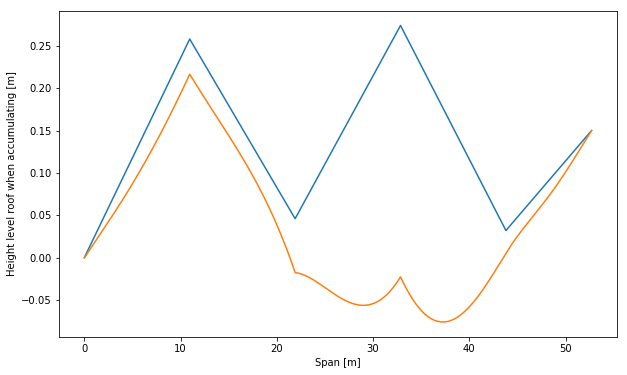

In [84]:
plt.figure(figsize=(10, 6))

plt.plot(ss.nodes_range('x')[:-2], ss.nodes_range('y')[:-2])
plt.plot(ss.nodes_range('x')[:-2], [a + b for a, b in zip(ss.nodes_range('y')[:-2], ss.get_node_result_range("uy")[:-2])])

plt.ylabel("Height level roof when accumulating [m]")
plt.xlabel("Span [m]")
plt.show()